<a href="https://colab.research.google.com/github/xyt556/Geo_Programme/blob/main/05_xarray_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 概述

许多气候和气象数据集以网格栅格的形式存在，数据格式如 NetCDF 和 GRIB。我们将使用 [XArray](http://xarray.pydata.org/) 来读取、处理和可视化这些网格栅格数据集。

XArray 是 rasterio 的进化版，受 pandas 等库的启发，用于处理栅格数据集。它特别适合处理多维时间序列栅格数据集。它还与 dask 紧密集成，允许使用并行计算来扩展栅格数据处理。XArray 提供了基于 Matplotlib 的[绘图功能](https://xarray.pydata.org/en/stable/user-guide/plotting.html)。

在本节中，我们将使用 GISTEMP 提供的[网格化月度温度异常数据](https://data.giss.nasa.gov/gistemp/)，从1880年至今，并可视化2021年的温度异常情况。

## 设置和数据下载

以下代码块将安装所需的软件包并将数据集下载到您的Colab环境中。

In [ ]:
!pip install xarray

In [ ]:
import os
import matplotlib.pyplot as plt
import xarray as xr

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

filename = 'gistemp1200_GHCNv4_ERSSTv5.nc'
data_url = 'https://github.com/xyt556/python-dataviz-web/raw/main/data/gistemp/'

download(data_url + filename)

Downloaded data/gistemp1200_GHCNv4_ERSSTv5.nc


## XArray 技术

按照惯例，XArray 被导入为 `xr`。我们使用 XArray 的 `open_dataset()` 方法来读取网格栅格数据。结果是一个 `xarray.Dataset` 对象。

In [ ]:
file_path = os.path.join(data_folder, filename)
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset> Size: 110MB
Dimensions:      (lat: 90, lon: 180, time: 1704, nv: 2)
Coordinates:
  * lat          (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon          (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 14kB 1880-01-15 1880-02-15 ... 2021-12-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] 27kB ...
    tempanomaly  (time, lat, lon) float32 110MB ...
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2022-01-11 09:09:58 by SBBX_to_nc 2.0 - ILAND=1200,...

NetCDF 文件包含从 1880 年到 2021 年每个月的值网格，空间分辨率为 2 度。让我们了解数据集中包含的内容。

* **变量**：这类似于栅格数据集中的波段。每个变量包含一个值数组。
* **维度**：这类似于数组轴的数量。
* **坐标**：这些是每个维度中值的标签。
* **属性**：这是与数据集相关的元数据。

<img src='https://courses.spatialthoughts.com/images/python_dataviz/xarray_terminology.png' width=800/>

一个数据集由一个或多个 `xarray.DataArray` 对象组成。这是主要对象，包含一个具有维度名称、坐标和属性的单变量。您可以使用 `dataset.variable_name` 语法访问每个变量。

让我们看看 `time_bnds` 变量。它包含一个二维数组，其中包含每个平均周期的开始和结束时间。

In [ ]:
ds.time_bnds

<xarray.DataArray 'time_bnds' (time: 1704, nv: 2)> Size: 27kB
[3408 values with dtype=datetime64[ns]]
Coordinates:
  * time     (time) datetime64[ns] 14kB 1880-01-15 1880-02-15 ... 2021-12-15
Dimensions without coordinates: nv

主要关注的变量是 `tempanomaly`，它包含不同时间的温度异常值网格。让我们选择该变量并将其存储为 `da`。

In [ ]:
da = ds.tempanomaly
da

<xarray.DataArray 'tempanomaly' (time: 1704, lat: 90, lon: 180)> Size: 110MB
[27604800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * time     (time) datetime64[ns] 14kB 1880-01-15 1880-02-15 ... 2021-12-15
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

## 选择数据

XArray 提供了一种非常强大的数据子集选择方式，使用的框架类似于 Pandas。与 Pandas 的 `loc` 和 `iloc` 方法类似，XArray 提供了 `sel` 和 `isel` 方法。由于 DataArray 维度具有名称，这些方法允许您指定要查询的维度。

让我们选择最后一个时间步的温度异常值。由于我们知道数据的索引（-1），可以使用 `isel` 方法。

In [ ]:
da.isel(time=-2)

<xarray.DataArray 'tempanomaly' (lat: 90, lon: 180)> Size: 65kB
[16200 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
    time     datetime64[ns] 8B 2021-11-15
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

我们还可以使用 `sel()` 方法指定一个值进行查询。

In [ ]:
da.sel(time='2020-12-15')

<xarray.DataArray 'tempanomaly' (lat: 90, lon: 180)> Size: 65kB
[16200 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
    time     datetime64[ns] 8B 2020-12-15
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

我们可以指定多个维度来查询一个子集。让我们提取 `lat=49`、`lon=-123` 和 `time='2021-06-15'` 的温度异常值。该地区在2021年6月经历了异常高温。

(1) 2021 Global Temperature Anomaly Since 1850 - Berkeley Earth. https://berkeleyearth.org/dv/2021-global-temperature-changes-since-1850-2/.
(2) August 2021 Global Climate Report | National Centers for Environmental .... https://www.ncei.noaa.gov/access/monitoring/monthly-report/global/202108.
(3) Global Surface Temperature Anomalies | National Centers for .... https://www.ncei.noaa.gov/access/monitoring/global-temperature-anomalies.
(4) April 2021 Global Climate Report | National Centers for Environmental .... https://www.ncei.noaa.gov/access/monitoring/monthly-report/global/202104.

In [ ]:
a = da.sel(lat=49.2, lon=-123.2)
a

KeyError: "not all values found in index 'lat'. Try setting the `method` keyword argument (example: method='nearest')."

`sel()` 方法还支持最近邻查找。当您不知道维度的确切标签，但想找到最接近的标签时，这非常有用。

> 提示：您可以使用 `interp()` 而不是 `sel()` 来插值值，而不是最近查找。

In [ ]:
da.sel(lat=28.6, lon=77.2, time='2021-05-01', method='nearest')

<xarray.DataArray 'tempanomaly' ()> Size: 4B
[1 values with dtype=float32]
Coordinates:
    lat      float32 4B 29.0
    lon      float32 4B 77.0
    time     datetime64[ns] 8B 2021-05-15
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

您可以在 DataArray 上调用 `.values` 来获取值数组。

In [ ]:
selected = da.sel(time='2021-05-01', method='nearest')
print(selected.values)

[[-0.45      -0.45      -0.45      ... -0.45      -0.45      -0.45     ]
 [-0.45      -0.45      -0.45      ... -0.45      -0.45      -0.45     ]
 [-0.45      -0.45      -0.45      ... -0.45      -0.45      -0.45     ]
 ...
 [ 1.9599999  1.9599999  1.9599999 ...  1.9599999  1.9599999  1.9599999]
 [ 1.9599999  1.9599999  1.9599999 ...  1.9599999  1.9599999  1.9599999]
 [ 1.9599999  1.9599999  1.9599999 ...  1.9599999  1.9599999  1.9599999]]


`sel()` 方法还允许使用 Python 内置的 `slice()` 函数指定值的范围。以下代码将选择 2021 年的所有观测值。

(1) Python slice() Function - W3Schools. https://www.w3schools.com/python/ref_func_slice.asp.
(2) Python slice() 函数 - w3school 在线教程. https://www.w3school.com.cn/python/ref_func_slice.asp.
(3) Python slice() function - GeeksforGeeks. https://www.geeksforgeeks.org/python-slice-function/.
(4) 2021 Global Temperature Anomaly Since 1850 - Berkeley Earth. https://berkeleyearth.org/dv/2021-global-temperature-changes-since-1850-2/.
(5) August 2021 Global Climate Report | National Centers for Environmental .... https://www.ncei.noaa.gov/access/monitoring/monthly-report/global/202108.
(6) Global Surface Temperature Anomalies | National Centers for .... https://www.ncei.noaa.gov/access/monitoring/global-temperature-anomalies.
(7) April 2021 Global Climate Report | National Centers for Environmental .... https://www.ncei.noaa.gov/access/monitoring/monthly-report/global/202104.

In [ ]:
da.sel(time=slice('2021-01-01', '2021-12-31'))

<xarray.DataArray 'tempanomaly' (time: 12, lat: 90, lon: 180)> Size: 778kB
[194400 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * time     (time) datetime64[ns] 96B 2021-01-15 2021-02-15 ... 2021-12-15
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

## 掩膜和数据子集

XArray 具有 [`where()`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.where.html) 函数，该函数允许您提取数组的子集。以下代码块提取特定纬度/经度的异常值。然后我们使用 `.where()` 函数选择具有正异常的项目。

In [ ]:
selected = da.sel(lat=28.6, lon=77.2, method='nearest')
selected

<xarray.DataArray 'tempanomaly' (time: 1704)> Size: 7kB
[1704 values with dtype=float32]
Coordinates:
    lat      float32 4B 29.0
    lon      float32 4B 77.0
  * time     (time) datetime64[ns] 14kB 1880-01-15 1880-02-15 ... 2021-12-15
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

我们可以使用 `drop=True` 来删除所有不符合条件的项目，并创建数据的子集。

In [ ]:
positive = selected.where(selected > 0, drop=True)
positive

<xarray.DataArray 'tempanomaly' (time: 798)> Size: 3kB
array([0.38      , 2.76      , 1.54      , 0.06      , 1.15      ,
       0.07      , 0.79999995, 0.45      , 0.45999998, 0.72999996,
       0.83      , 0.41      , 0.26      , 0.09      , 0.24      ,
       0.93      , 0.93      , 0.35      , 0.68      , 0.85999995,
       0.69      , 0.02      , 0.94      , 0.32999998, 0.28      ,
       0.16      , 0.22      , 1.0799999 , 1.14      , 0.31      ,
       1.3399999 , 2.74      , 0.56      , 0.28      , 1.41      ,
       0.04      , 0.66999996, 0.53      , 0.38      , 0.84      ,
       1.23      , 0.42      , 0.09      , 0.09      , 0.95      ,
       0.59      , 0.94      , 1.8299999 , 0.26999998, 0.09999999,
       1.12      , 0.76      , 1.15      , 0.95      , 0.13      ,
       0.37      , 0.87      , 1.38      , 0.72999996, 0.88      ,
       0.09999999, 0.59999996, 0.72999996, 0.76      , 0.79999995,
       0.14      , 1.13      , 0.58      , 1.4       , 0.24      ,
       0.35999998, 0.08      , 0.51      , 0.89      , 1.2099999 ,
       0.08      , 0.48      , 0.87      , 0.61      , 0.22      ,
       0.68      , 0.06      , 0.42999998, 1.51      , 0.14999999,
       0.57      , 0.45      , 1.51      , 1.3199999 , 0.09999999,
       0.48999998, 0.74      , 0.04      , 0.48999998, 0.51      ,
       0.16      , 0.68      , 0.97999996, 1.4       , 0.71      ,
...
       0.39      , 0.38      , 0.89      , 1.35      , 1.15      ,
       0.32999998, 0.21      , 0.04      , 0.5       , 0.76      ,
       0.52      , 1.01      , 0.19      , 1.31      , 0.29999998,
       0.14      , 1.01      , 1.05      , 0.22      , 0.75      ,
       0.21      , 1.25      , 1.11      , 1.0699999 , 0.52      ,
       0.87      , 1.17      , 1.8199999 , 0.04      , 1.12      ,
       0.12      , 0.65999997, 1.0799999 , 1.42      , 1.75      ,
       0.85999995, 1.5799999 , 1.8       , 1.76      , 1.88      ,
       1.4499999 , 0.98999995, 0.35      , 0.32999998, 1.22      ,
       1.38      , 1.14      , 2.29      , 0.72999996, 1.75      ,
       0.90999997, 2.07      , 1.43      , 0.29999998, 0.82      ,
       0.97999996, 1.8       , 0.62      , 1.13      , 1.35      ,
       2.2       , 2.56      , 1.56      , 1.31      , 0.53999996,
       0.53999996, 0.82      , 0.35999998, 0.55      , 1.27      ,
       0.17      , 0.35999998, 1.54      , 0.47      , 1.06      ,
       0.96      , 0.75      , 1.22      , 0.42      , 1.14      ,
       0.81      , 0.09999999, 0.11      , 1.2099999 , 1.05      ,
       1.49      , 1.05      , 0.35      , 0.57      , 2.46      ,
       2.4199998 , 0.68      , 1.09      , 1.01      , 0.94      ,
       0.90999997, 0.62      , 0.28      ], dtype=float32)
Coordinates:
    lat      float32 4B 29.0
    lon      float32 4B 77.0
  * time     (time) datetime64[ns] 6kB 1880-01-15 1880-03-15 ... 2021-12-15
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

## 聚合数据

XArray 的一个非常强大的功能是能够轻松地跨维度聚合数据，这使其非常适合许多遥感分析。让我们计算2021年的平均温度异常值。

我们首先选择2021年的子集，并在 `time` 维度上应用 `.mean()` 聚合。

In [ ]:
subset2021 = da.sel(time=slice('2021-01-01', '2021-12-31'))
subset2021.mean(dim='time')

<xarray.DataArray 'tempanomaly' (lat: 90, lon: 180)> Size: 65kB
array([[-1.0675001, -1.0675001, -1.0675001, ..., -1.0675001, -1.0675001,
        -1.0675001],
       [-1.0675001, -1.0675001, -1.0675001, ..., -1.0675001, -1.0675001,
        -1.0675001],
       [-1.0675001, -1.0675001, -1.0675001, ..., -1.0675001, -1.0675001,
        -1.0675001],
       ...,
       [ 3.7291667,  3.7291667,  3.7291667, ...,  3.7291667,  3.7291667,
         3.7291667],
       [ 3.7291667,  3.7291667,  3.7291667, ...,  3.7291667,  3.7291667,
         3.7291667],
       [ 3.7291667,  3.7291667,  3.7291667, ...,  3.7291667,  3.7291667,
         3.7291667]], dtype=float32)
Coordinates:
  * lat      (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0

In [ ]:
da_y = da.resample(time='6M')
da_y

<string>:6: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.


<DataArrayResample, grouped over 1 grouper(s), 285 groups in total:
    '__resample_dim__': 285 groups with labels 1880-01-31, ..., 2022-01-31>

XArray 具有许多功能，可以轻松处理这样的时间序列数据。我们可以使用时间组件来跨时间聚合数据。在这里，我们将每月的异常时间序列使用 `groupby()` 方法聚合为年度时间序列。

参考：[重采样和分组操作](https://docs.xarray.dev/en/stable/user-guide/time-series.html#resampling-and-grouped-operations)

1. **`data.groupby('time.year')`**:
   - **功能**：`groupby` 按照 `time` 维度中的 `year` 属性对数据进行分组。  
   - **使用场景**：适用于数据中已经有 `year` 这样的时间组件，并且你希望基于年份对数据进行分组。每个年份的数据将成为一个组。
   - **返回结果**：返回一个分组对象，后续可以对每个组进行聚合计算，如求均值、求和等。

   ```python
   annual_mean = data.groupby('time.year').mean()
   ```

   这会按年份对 `time` 维度进行分组，并计算每一年的均值。

   **总结**：`groupby` 操作不会改变原数据的时间结构，而是基于现有时间组件（如 `year`、`month`）对数据分组。

2. **`data.resample('time.year')`**:
   - **功能**：`resample` 是基于时间频率重采样数据，适用于时间连续的数据。你可以将原始数据按年、月、日等频率重新采样或聚合。
   - **使用场景**：当你有一个连续的时间序列数据时，可以使用 `resample` 对数据进行重采样。比如，将日数据重采样为月数据或年数据。
   - **返回结果**：返回一个可以进一步聚合的重采样对象。例如，使用 `.mean()` 计算每年的均值。

   ```python
   annual_mean = data.resample(time='1Y').mean()
   ```

   这会将数据按每年重新采样，并计算每年的平均值。`'1Y'` 表示按一年为单位进行重采样。

   **总结**：`resample` 是基于时间的重采样方法，适用于时间间隔一致的数据。它不仅可以按年采样，还可以按月、按日等其他时间频率进行采样。

### 区别总结
- **`groupby('time.year')`**：基于时间维度的 `year` 组件对数据分组，只适用于数据中已经存在的时间信息，不改变数据的时间索引。
- **`resample('time.year')`**：根据指定的时间频率（如每年）对数据进行重采样，适用于连续的时间序列数据，重采样后会改变时间索引。



In [ ]:
!pip install --upgrade xarray scipy dask


In [ ]:
yearly = da.groupby('time.year').mean(dim='time')
yearly


<xarray.DataArray 'tempanomaly' (year: 142, lat: 90, lon: 180)> Size: 9MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 3.7966664 ,  3.7966664 ,  3.7966664 , ...,  3.7966664 ,
          3.7966664 ,  3.7966664 ],
        [ 3.7966664 ,  3.7966664 ,  3.7966664 , ...,  3.7966664 ,
          3.7966664 ,  3.7966664 ],
        [ 3.7966664 ,  3.7966664 ,  3.7966664 , ...,  3.7966664 ,
          3.7966664 ,  3.7966664 ]],

       [[-1.0675001 , -1.0675001 , -1.0675001 , ..., -1.0675001 ,
         -1.0675001 , -1.0675001 ],
        [-1.0675001 , -1.0675001 , -1.0675001 , ..., -1.0675001 ,
         -1.0675001 , -1.0675001 ],
        [-1.0675001 , -1.0675001 , -1.0675001 , ..., -1.0675001 ,
         -1.0675001 , -1.0675001 ],
        ...,
        [ 3.7291667 ,  3.7291667 ,  3.7291667 , ...,  3.7291667 ,
          3.7291667 ,  3.7291667 ],
        [ 3.7291667 ,  3.7291667 ,  3.7291667 , ...,  3.7291667 ,
          3.7291667 ,  3.7291667 ],
        [ 3.7291667 ,  3.7291667 ,  3.7291667 , ...,  3.7291667 ,
          3.7291667 ,  3.7291667 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * year     (year) int64 1kB 1880 1881 1882 1883 1884 ... 2018 2019 2020 2021
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

In [ ]:
da = da.load()  # 如果出错，需加这条语句
yearly = da.groupby('time.year')

# 按年份分组后，进行均值计算
annual_mean = yearly.mean(dim='time')
annual_mean

<xarray.DataArray 'tempanomaly' (year: 142, lat: 90, lon: 180)> Size: 9MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 3.7966664 ,  3.7966664 ,  3.7966664 , ...,  3.7966664 ,
          3.7966664 ,  3.7966664 ],
        [ 3.7966664 ,  3.7966664 ,  3.7966664 , ...,  3.7966664 ,
          3.7966664 ,  3.7966664 ],
        [ 3.7966664 ,  3.7966664 ,  3.7966664 , ...,  3.7966664 ,
          3.7966664 ,  3.7966664 ]],

       [[-1.0675001 , -1.0675001 , -1.0675001 , ..., -1.0675001 ,
         -1.0675001 , -1.0675001 ],
        [-1.0675001 , -1.0675001 , -1.0675001 , ..., -1.0675001 ,
         -1.0675001 , -1.0675001 ],
        [-1.0675001 , -1.0675001 , -1.0675001 , ..., -1.0675001 ,
         -1.0675001 , -1.0675001 ],
        ...,
        [ 3.7291667 ,  3.7291667 ,  3.7291667 , ...,  3.7291667 ,
          3.7291667 ,  3.7291667 ],
        [ 3.7291667 ,  3.7291667 ,  3.7291667 , ...,  3.7291667 ,
          3.7291667 ,  3.7291667 ],
        [ 3.7291667 ,  3.7291667 ,  3.7291667 , ...,  3.7291667 ,
          3.7291667 ,  3.7291667 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * year     (year) int64 1kB 1880 1881 1882 1883 1884 ... 2018 2019 2020 2021
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

In [ ]:
import xarray as xr

# 假设 `da` 是一个包含时间维度的 DataArray
# 例如，da 是月度异常时间序列数据

# 使用 groupby() 将数据按年份分组，并计算每年平均值
annual_mean = da.groupby('time.year').mean(dim='time')

# 查看年度聚合后的结果
print(annual_mean)


<xarray.DataArray 'tempanomaly' (year: 142, lat: 90, lon: 180)> Size: 9MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,        

## 练习

您能找出特定位置的最高温度异常发生的时间吗？

将以下代码中的 `lat` 和 `lon` 替换为您选择的位置。您将看到生成的 `max_anomaly` DataArray，其中包含异常值以及纬度、经度和时间坐标。提取生成数组的 `time` 坐标并打印最大异常发生的时间。

(1) How much have temperatures risen in countries across the world?. https://ourworldindata.org/temperature-anomaly.
(2) NASA SVS | Global Temperature Anomalies from 1880 to 2023. https://svs.gsfc.nasa.gov/5207/.
(3) August 2021 Global Climate Report | National Centers for Environmental .... https://www.ncei.noaa.gov/access/monitoring/monthly-report/global/202108.
(4) Shifting Distribution of Land Temperature Anomalies, 1962-2023. https://svs.gsfc.nasa.gov/5211.
(5) undefined. https://www.nasa.gov/earth.
(6) 2021 Global Temperature Anomaly Since 1850 - Berkeley Earth. https://berkeleyearth.org/dv/2021-global-temperature-changes-since-1850-2/.
(7) Global Surface Temperature Anomalies | National Centers for .... https://www.ncei.noaa.gov/access/monitoring/global-temperature-anomalies.
(8) April 2021 Global Climate Report | National Centers for Environmental .... https://www.ncei.noaa.gov/access/monitoring/monthly-report/global/202104.

In [ ]:
selected = da.sel(lat=28.6, lon=77.2, method='nearest')
max_anomaly = selected.where(selected==selected.max(), drop=True)
max_anomaly

<xarray.DataArray 'tempanomaly' (time: 1)> Size: 4B
array([4.39], dtype=float32)
Coordinates:
    lat      float32 4B 29.0
    lon      float32 4B 77.0
  * time     (time) datetime64[ns] 8B 2006-02-15
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

## 可视化


要可视化 `xarray.DataArray` 数据，通常可以使用以下几种方法。具体方法取决于数据的维度和您希望展示的内容。`xarray` 提供了内置的可视化功能，并且与 `matplotlib` 和 `cartopy` 等可视化库很好地集成。















### 1. **直接使用 `xarray` 内置的 `plot()` 方法**
   如果你的数据是二维的或更高维度，可以使用 `xarray` 自带的 `plot()` 方法进行快速可视化。
   ```python
   da.plot()  # 可视化第一个时间步的数据
   ```
   #### 对于二维数据：
   假设 `da` 是一个二维的 `xarray.DataArray`，比如（经度、纬度）上的某个物理量，可以直接使用 `.plot()`：

   #### 对于三维数据：
   如果数据具有时间维度（比如 `time`, `latitude`, `longitude`），你可以通过选择某个时间点或维度来可视化该时间点的二维数据：

   ```python
   da.isel(time=0).plot()  # 可视化第一个时间步的数据
   ```

   或者你可以按某个维度进行聚合后再绘图：

   ```python
   da.mean(dim='time').plot()  # 对时间维度取平均后绘制
   ```


(array([3.860000e+02, 6.859000e+03, 5.342900e+04, 4.338660e+05,
        1.199511e+07, 1.133900e+07, 6.061700e+05, 8.330000e+04,
        9.306000e+03, 1.038000e+03]),
 array([-15.85999966, -12.67499924,  -9.48999977,  -6.30499983,
         -3.11999989,   0.06500006,   3.25      ,   6.43499994,
          9.61999989,  12.80500031,  15.98999977]),
 <BarContainer object of 10 artists>)

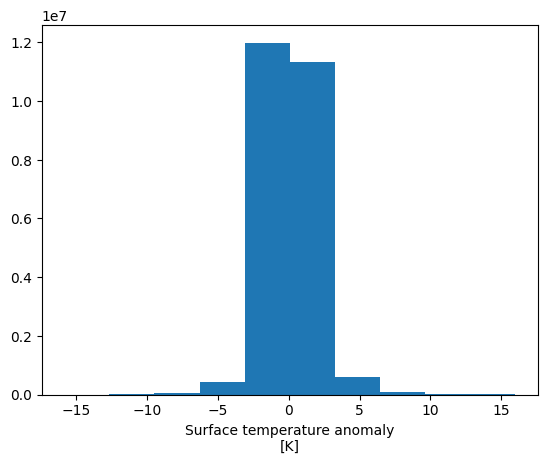

In [ ]:
da.plot()

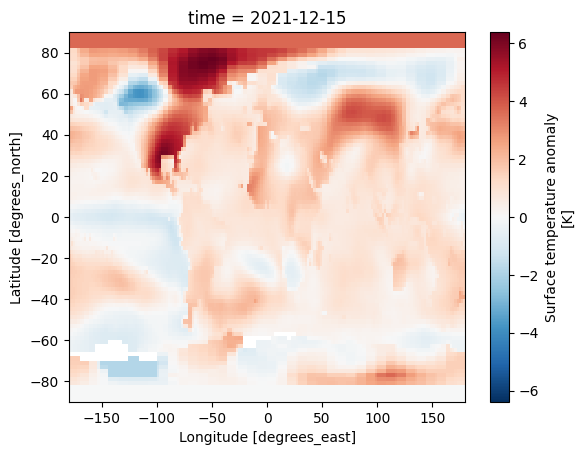

In [ ]:
da.isel(time=-1).plot()

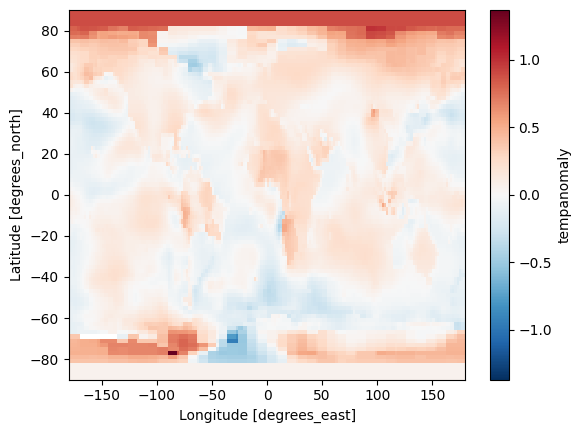

In [ ]:
# 对时间维度取平均后绘制
da.mean(dim='time').plot()

   这个方法会自动生成合适的图表（通常是 `imshow()` 或 `contourf()`），并且添加坐标轴、颜色条等。


### 2. **使用 `matplotlib` 自定义绘图**
   `xarray` 和 `matplotlib` 配合得很好，您可以提取 `DataArray` 的原始数据并使用 `matplotlib` 进行自定义绘制。


Coordinates:
  * lat      (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * time     (time) datetime64[ns] 14kB 1880-01-15 1880-02-15 ... 2021-12-15


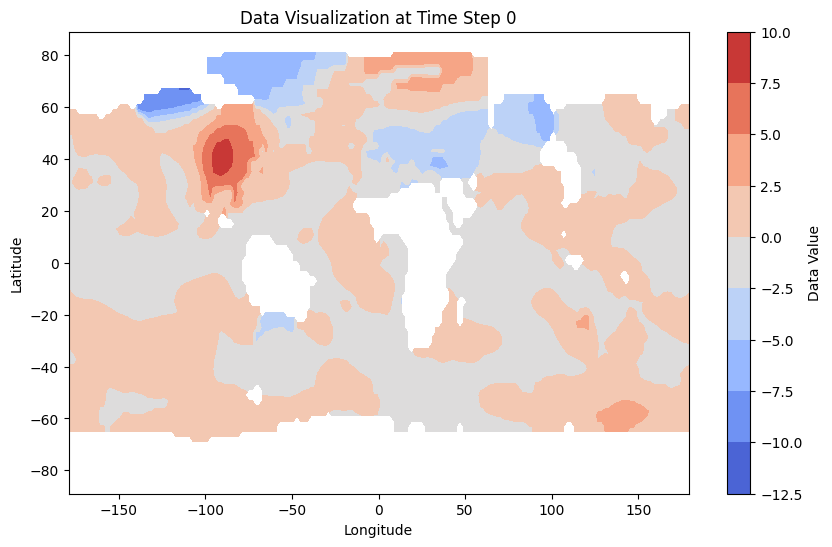

In [ ]:
import matplotlib.pyplot as plt

# 提取数据
data = da.isel(time=0).values  # 第一个时间步的数据

# 查看正确的坐标名称
print(da.coords)

# 假设坐标名称是 lon 和 lat
lon = da.coords['lon'].values
lat = da.coords['lat'].values

# 绘制
plt.figure(figsize=(10, 6))
plt.contourf(lon, lat, data, cmap='coolwarm')
plt.colorbar(label='Data Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Data Visualization at Time Step 0')
plt.show()


In [ ]:
yearly = da.groupby('time.year').mean(dim='time')
yearly

<xarray.DataArray 'tempanomaly' (year: 142, lat: 90, lon: 180)> Size: 9MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 3.7966664 ,  3.7966664 ,  3.7966664 , ...,  3.7966664 ,
          3.7966664 ,  3.7966664 ],
        [ 3.7966664 ,  3.7966664 ,  3.7966664 , ...,  3.7966664 ,
          3.7966664 ,  3.7966664 ],
        [ 3.7966664 ,  3.7966664 ,  3.7966664 , ...,  3.7966664 ,
          3.7966664 ,  3.7966664 ]],

       [[-1.0675001 , -1.0675001 , -1.0675001 , ..., -1.0675001 ,
         -1.0675001 , -1.0675001 ],
        [-1.0675001 , -1.0675001 , -1.0675001 , ..., -1.0675001 ,
         -1.0675001 , -1.0675001 ],
        [-1.0675001 , -1.0675001 , -1.0675001 , ..., -1.0675001 ,
         -1.0675001 , -1.0675001 ],
        ...,
        [ 3.7291667 ,  3.7291667 ,  3.7291667 , ...,  3.7291667 ,
          3.7291667 ,  3.7291667 ],
        [ 3.7291667 ,  3.7291667 ,  3.7291667 , ...,  3.7291667 ,
          3.7291667 ,  3.7291667 ],
        [ 3.7291667 ,  3.7291667 ,  3.7291667 , ...,  3.7291667 ,
          3.7291667 ,  3.7291667 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * year     (year) int64 1kB 1880 1881 1882 1883 1884 ... 2018 2019 2020 2021
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

In [ ]:
anomaly2021 = yearly.sel(year=2021)
anomaly2021

<xarray.DataArray 'tempanomaly' (lat: 90, lon: 180)> Size: 65kB
array([[-1.0675001, -1.0675001, -1.0675001, ..., -1.0675001, -1.0675001,
        -1.0675001],
       [-1.0675001, -1.0675001, -1.0675001, ..., -1.0675001, -1.0675001,
        -1.0675001],
       [-1.0675001, -1.0675001, -1.0675001, ..., -1.0675001, -1.0675001,
        -1.0675001],
       ...,
       [ 3.7291667,  3.7291667,  3.7291667, ...,  3.7291667,  3.7291667,
         3.7291667],
       [ 3.7291667,  3.7291667,  3.7291667, ...,  3.7291667,  3.7291667,
         3.7291667],
       [ 3.7291667,  3.7291667,  3.7291667, ...,  3.7291667,  3.7291667,
         3.7291667]], dtype=float32)
Coordinates:
  * lat      (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
    year     int64 8B 2021
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

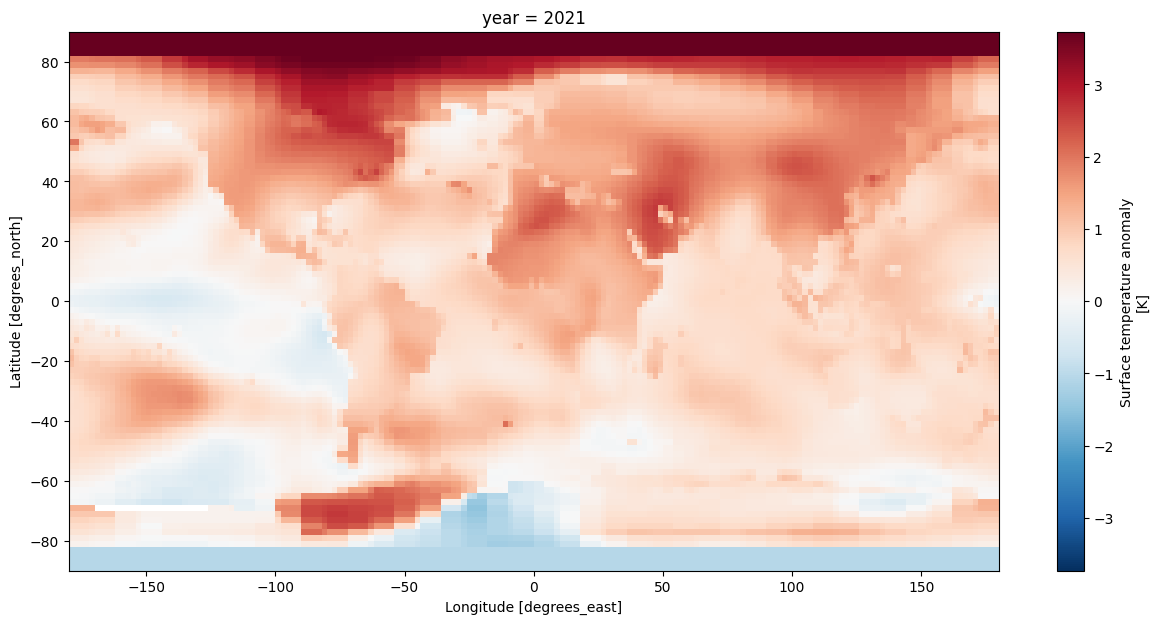

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
anomaly2021.plot(ax=ax)
plt.show()

虽然 `plot()` 方法有效，但在渲染大型二维数组时，它比 `plot.imshow()` 方法要慢。因此，我们更倾向于使用 `plot.imshow()` 方法而不是 `plot()` 方法。

参考：[xarray.plot.imshow](https://docs.xarray.dev/en/stable/generated/xarray.plot.imshow.html)


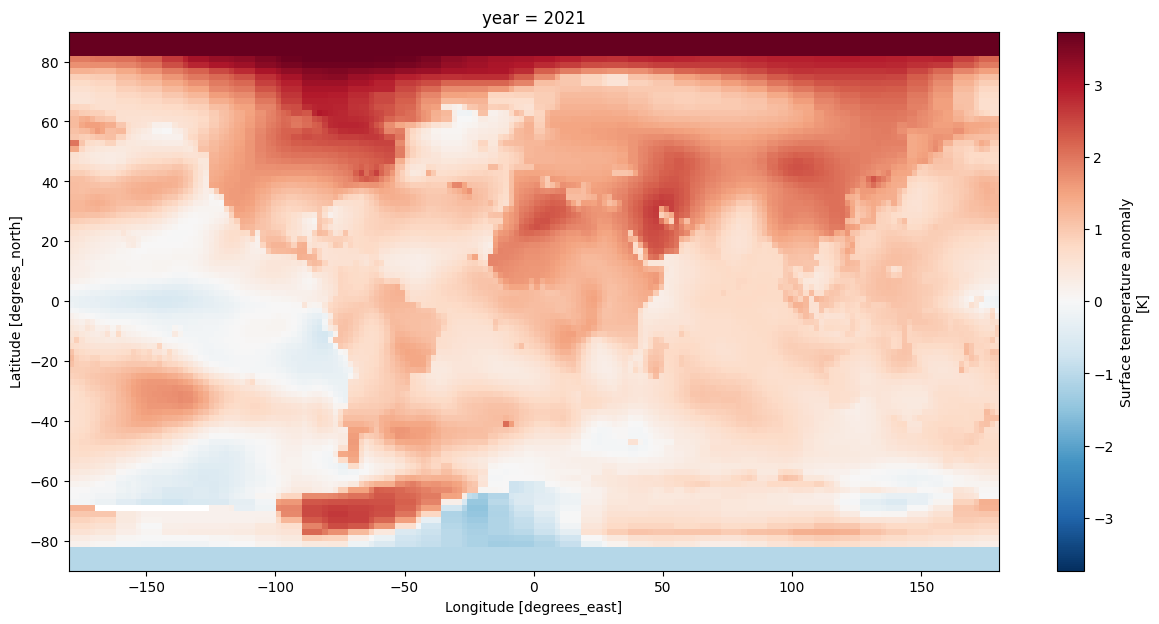

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
anomaly2021.plot.imshow(ax=ax)
plt.show()

我们可以使用 Matplotlib 的选项自定义绘图。

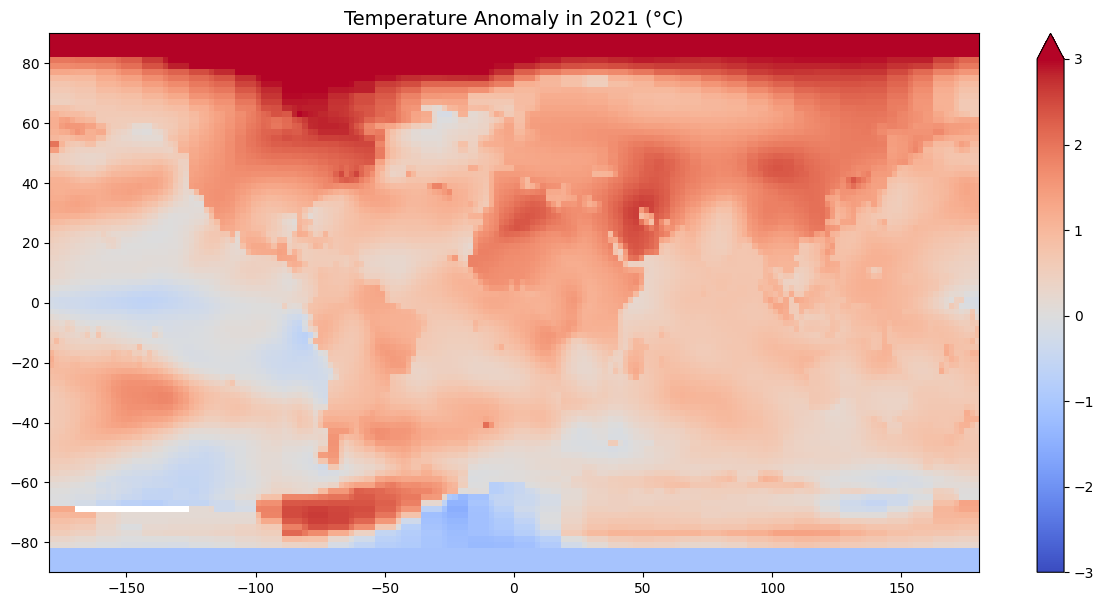

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)

anomaly2021.plot.imshow(ax=ax,
    vmin=-3, vmax=3, add_labels=False, cmap='coolwarm')

ax.set_title('Temperature Anomaly in 2021 (°C)', fontsize = 14)

plt.show()

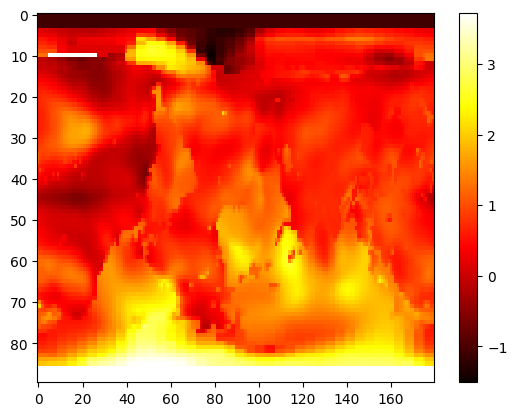

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 使用 imshow 绘制热图
plt.imshow(anomaly2021, cmap='hot', interpolation='nearest', aspect='auto')
plt.colorbar()  # 添加颜色条
plt.show()


`matplotlib.pyplot.imshow()` 是用于显示图像的函数，它能够显示二维数组、热图或图像数据。以下是 `imshow()` 函数的一些主要参数及其用途：

### 基本语法

```python
import matplotlib.pyplot as plt
plt.imshow(X, cmap=None, interpolation=None, norm=None, vmin=None, vmax=None, aspect=None, **kwargs)
```

### 主要参数

1. **X (必选参数)**:
   - **描述**: 这是一个二维的图像数据，通常是 `NumPy` 数组或类似的对象。
   - **数据类型**: array-like（如 2D 数组）

2. **cmap (str or Colormap, 可选)**:
   - **描述**: 指定用于颜色映射的色彩表（colormap）。这决定了数据如何映射到颜色空间。
   - **常见选项**: `'viridis'`, `'plasma'`, `'inferno'`, `'gray'`, `'hot'`, `'coolwarm'` 等。
   - **默认**: 如果 `X` 是浮点数组，默认是 `'viridis'`；如果 `X` 是整数数组，则使用 `'gray'`。

3. **interpolation (str, 可选)**:
   - **描述**: 控制图像插值方式，用于缩放图像时平滑或锐化图像。
   - **常见选项**:
     - `'nearest'`: 最近邻插值（像素化效果）
     - `'bilinear'`, `'bicubic'`: 平滑插值
     - `'hamming'`, `'lanczos'`, `'gaussian'`: 高级插值方法
   - **默认**: `'nearest'`

4. **norm (Normalize, 可选)**:
   - **描述**: 一个 `matplotlib.colors.Normalize` 对象，用于将数据值标准化到 `[0, 1]` 的范围。它决定数据如何映射到色彩表中。
   - **默认**: `None`，表示自动标准化。

5. **vmin, vmax (scalar, 可选)**:
   - **描述**: 设置数据的最小值和最大值，以确定颜色映射范围。低于 `vmin` 的值会被映射为色彩表的第一个颜色，高于 `vmax` 的值则被映射为最后一个颜色。
   - **默认**: `None`，自动取决于数据的最小值和最大值。

6. **aspect (str or float, 可选)**:
   - **描述**: 控制图像的纵横比。
   - **选项**:
     - `'equal'`: 保持数据的比例关系。
     - `'auto'`: 自适应宽高比以填充轴区域。
     - `float`: 如 0.5 表示宽度是高度的一半。
   - **默认**: `'auto'`

7. **origin (str, 可选)**:
   - **描述**: 定义图像原点的放置位置（即数据在图中的定位方式）。
   - **选项**:
     - `'upper'`: 图像原点在左上角。
     - `'lower'`: 图像原点在左下角。
   - **默认**: `'upper'`

8. **extent (list, 可选)**:
   - **描述**: 用于定义图像的坐标范围 `[left, right, bottom, top]`。这可以将图像放置在自定义坐标系中。
   - **默认**: `None`，即图像像素的默认坐标。

9. **alpha (float, 可选)**:
   - **描述**: 控制图像的透明度，值范围为 `[0, 1]`，其中 0 表示完全透明，1 表示完全不透明。
   - **默认**: `None`，表示不应用透明度。

10. **filternorm (bool, 可选)**:
    - **描述**: 如果为 `True`，则使用标准化滤波器进行采样。
    - **默认**: `True`

11. **filterrad (float, 可选)**:
    - **描述**: 插值时用于采样的过滤器半径。默认值为 4.0。

12. **resample (bool, 可选)**:
    - **描述**: 如果 `True`，图像在显示时将被重新采样。
    - **默认**: `True`

13. **kwargs (其他关键字参数)**:
    - 可以传递更多 `matplotlib` 图像属性，如 `clim`（颜色限度）、`zorder`（图层顺序）等。

### 示例

```python
import matplotlib.pyplot as plt
import numpy as np

# 创建随机数据
data = np.random.rand(10, 10)

# 使用 imshow 绘制热图
plt.imshow(data, cmap='hot', interpolation='nearest', aspect='auto')
plt.colorbar()  # 添加颜色条
plt.show()
```

在这个示例中，`imshow()` 用随机数据绘制了一个热图，使用了 `hot` 色彩表，并且采用了最近邻插值。

### 3. **使用 `xarray.plot()` 带有 FacetGrid 的方法**
   如果你想同时显示多个时间步的数据，可以使用 `xarray` 的 `FacetGrid` 方法。它可以让你一次性绘制多个小图，每个子图代表不同的时间步或其他维度。

   ```python
   da.plot(col='time', col_wrap=4)  # 将时间维度分成多个子图
   ```

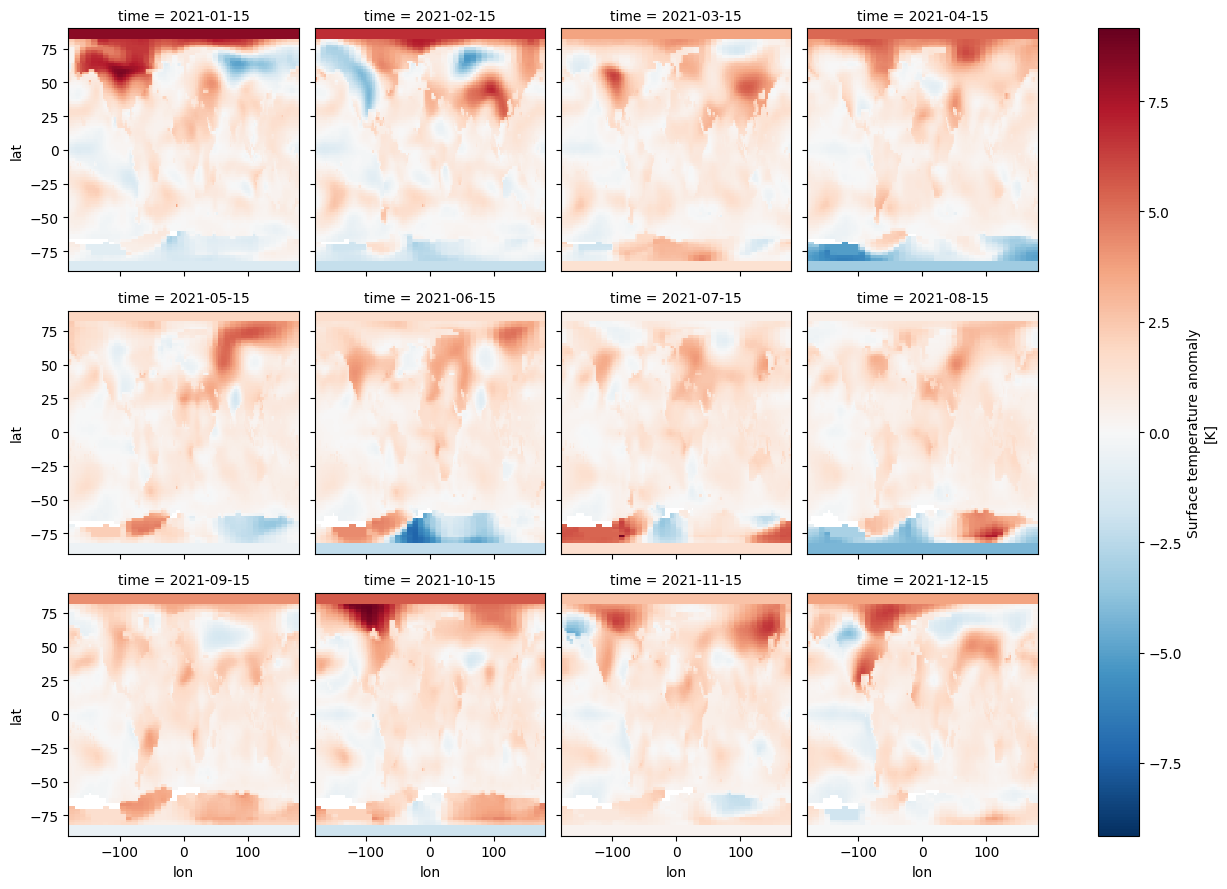

In [ ]:
subset2021 = da.sel(time=slice('2021-01-01', '2021-12-31'))
subset2021.plot(col='time', col_wrap=4)

### 4. **可视化时间序列**
   如果你想要绘制时间序列，例如某个位置的变量随时间变化，你可以这样做：

   ```python
   # 假设你有经度和纬度坐标
   ts = da.sel(latitude=51.5, longitude=0).plot()
   ```

   这将生成特定位置的时间序列图。

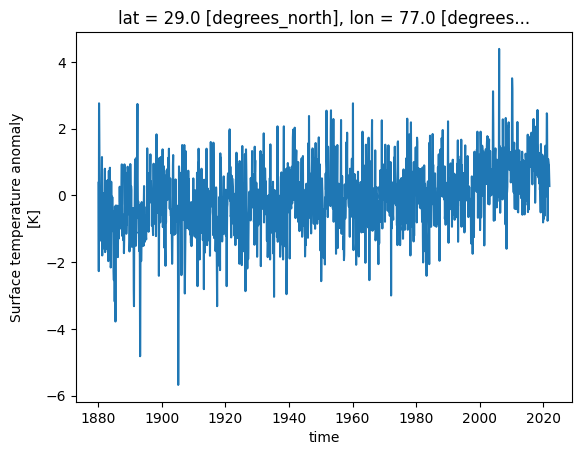

In [ ]:
ts = da.sel(lat=28.6, lon=77.2, method='nearest').plot()

### 5. **使用 `cartopy` 可视化地理数据**
   如果你的数据是地理相关的（例如，气候数据），你可以结合 `cartopy` 来生成地图投影的图形：

   

为了创建更具信息性的地图可视化，我们需要将这个网格重新投影到另一个投影。CartoPy 支持多种投影，并可以使用 Matplotlib 进行绘图。CartoPy 创建一个 GeoAxes 对象，并用它替换默认的 Axes。这使你可以在指定的投影上绘制数据。

我们像往常一样开始创建子图，但需要指定一个额外的参数来设置 CartoPy 的 CRS。

参考：[CartoPy 投影列表](https://scitools.org.uk/cartopy/docs/latest/reference/crs.html?highlight=list#list-of-projections)

源: 与 Copilot 的对话， 2024/9/13
(1) Cartopy projection list — cartopy 0.15.0 documentation - SciTools. https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html.
(2) Cartopy projection list — cartopy 0.23.0 documentation - SciTools. https://scitools.org.uk/cartopy/docs/latest/reference/projections.html.
(3) API reference — cartopy 0.23.0 documentation - SciTools. https://scitools.org.uk/cartopy/docs/latest/reference/index.html.

In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 74.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


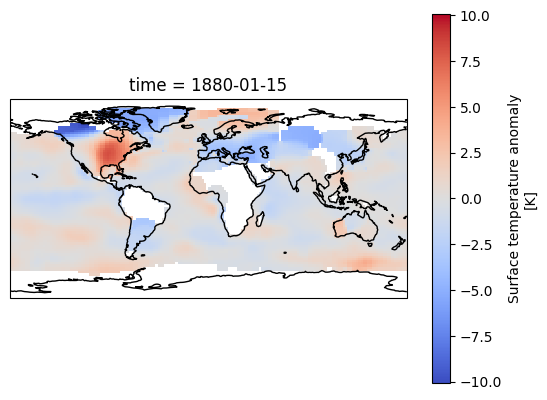

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# 创建地图投影
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
da.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')

# 添加海岸线
ax.coastlines()
plt.show()


In [ ]:
anomaly2021 = yearly.sel(year=2021)
anomaly2021

<xarray.DataArray 'tempanomaly' (lat: 90, lon: 180)> Size: 65kB
array([[-1.0675001, -1.0675001, -1.0675001, ..., -1.0675001, -1.0675001,
        -1.0675001],
       [-1.0675001, -1.0675001, -1.0675001, ..., -1.0675001, -1.0675001,
        -1.0675001],
       [-1.0675001, -1.0675001, -1.0675001, ..., -1.0675001, -1.0675001,
        -1.0675001],
       ...,
       [ 3.7291667,  3.7291667,  3.7291667, ...,  3.7291667,  3.7291667,
         3.7291667],
       [ 3.7291667,  3.7291667,  3.7291667, ...,  3.7291667,  3.7291667,
         3.7291667],
       [ 3.7291667,  3.7291667,  3.7291667, ...,  3.7291667,  3.7291667,
         3.7291667]], dtype=float32)
Coordinates:
  * lat      (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
    year     int64 8B 2021
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

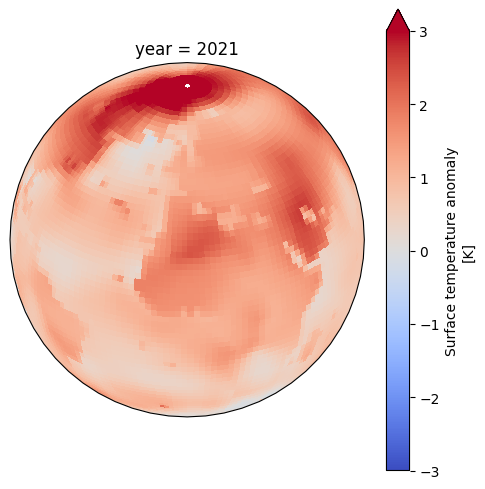

In [ ]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Orthographic(0, 30)})
fig.set_size_inches(5,5)

anomaly2021.plot.imshow(ax=ax,
    vmin=-3, vmax=3, cmap='coolwarm',
    transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

我们可以通过调整颜色条进一步自定义地图。

参考：[matplotlib.pyplot.colorbar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html)



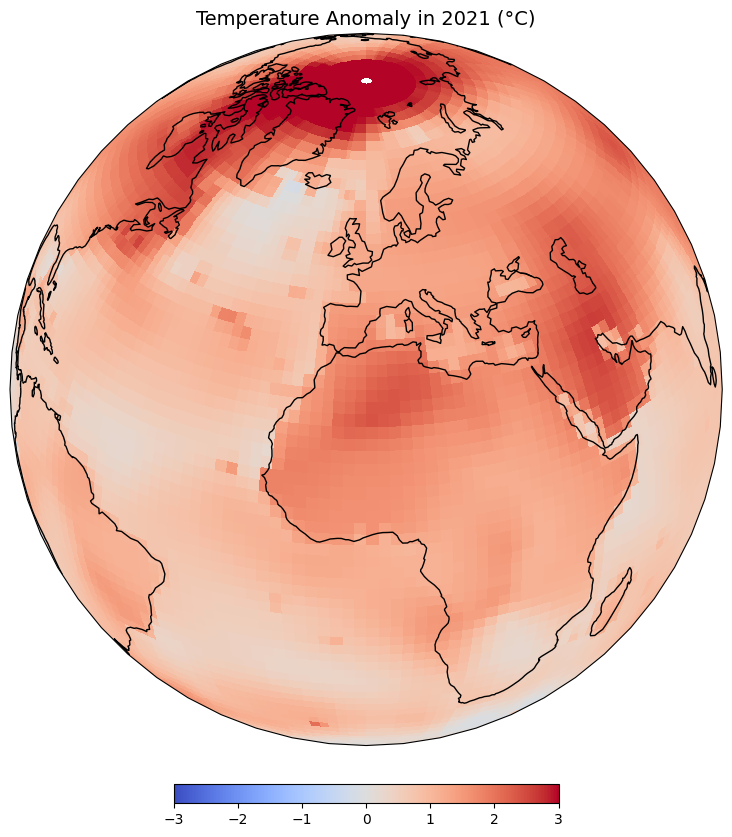

In [ ]:
cbar_kwargs = {
    'orientation':'horizontal',
    'fraction': 0.025,
    'pad': 0.05,
    'extend':'neither'
}

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Orthographic(0, 30)})
fig.set_size_inches(10, 10)
anomaly2021.plot.imshow(
    ax=ax,
    vmin=-3, vmax=3, cmap='coolwarm',
    transform=ccrs.PlateCarree(),
    add_labels=False,
    cbar_kwargs=cbar_kwargs)

ax.coastlines()
plt.title('Temperature Anomaly in 2021 (°C)', fontsize = 14)

output_folder = 'output'
output_path = os.path.join(output_folder, 'anomaly.jpg')
plt.savefig(output_path, dpi=300)
plt.show()

## 练习

在罗宾森投影中显示地图。


(1) NASA SVS | Global Temperature Anomalies from 1880 to 2017. https://svs.gsfc.nasa.gov/4609.
(2) NASA SVS | Global Temperature Anomalies from 1880 to 2023. https://svs.gsfc.nasa.gov/5207/.
(3) GitHub - biodiversity-monitoring/smap: smap: Sampling Points World Map .... https://github.com/biodiversity-monitoring/smap.
(4) 罗宾森投影—ArcGIS Pro | 文档. https://pro.arcgis.com/zh-cn/pro-app/latest/help/mapping/properties/robinson.htm.
(5) Plotting data on a map (Example Gallery) - basemap 1.4.1 ... - Matplotlib. https://matplotlib.org/basemap/stable/users/examples.html.
(6) undefined. http://data.giss.nasa.gov/gistemp/.
(7) undefined. https://www.nasa.gov/earth.
(8) undefined. https://downloads.psl.noaa.gov/Datasets/noaa.oisst.v2.highres/sst.day.mean.

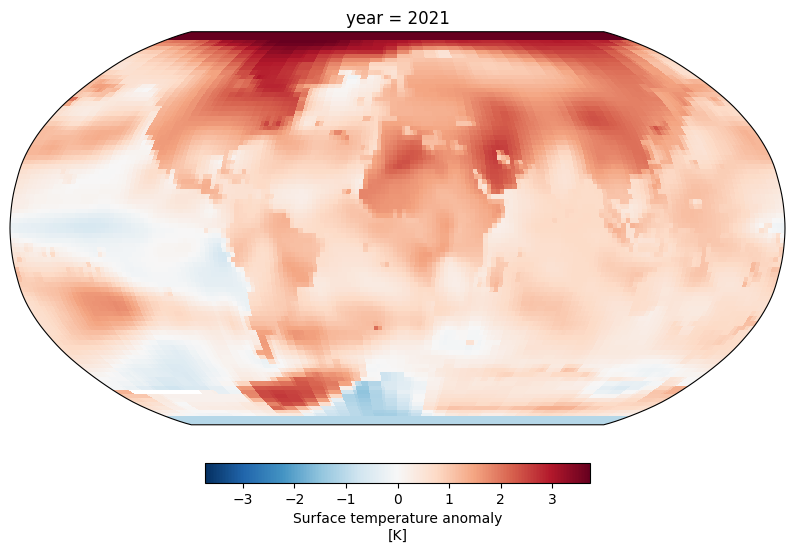

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os

# 设置颜色条参数
cbar_kwargs = {
    'orientation': 'horizontal',
    'fraction': 0.025,
    'pad': 0.05,
    'extend': 'neither'
}

# 创建一个罗宾森投影的子图
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()})
fig.set_size_inches(10, 10)

# 使用 `plot.imshow` 显示数据，并在罗宾森投影中显示地图
anomaly2021.plot.imshow(
    ax=ax,
    cbar_kwargs=cbar_kwargs,
    transform=ccrs.PlateCarree()  # 将数据坐标转换为平面投影坐标
)

# 设置输出路径并保存为高分辨率图片
output_folder = 'output'  # 确保文件夹存在
output_path = os.path.join(output_folder, 'anomaly_robinson.jpg')
plt.savefig(output_path, dpi=300)

# 显示图像
plt.show()


在 `Cartopy` 库中，有多种投影方式可供选择，具体取决于你要展示地图的类型。`Cartopy` 提供了多种常见的地图投影，每种投影适用于不同的应用场景。下面是一些常见的投影方式及其说明：

### 1. **平面投影 (Plate Carree)**
   - **`ccrs.PlateCarree()`**: 这是最基础的投影方式，通常用于展示原始的经纬度坐标。
   - **适用场景**: 适合展示简单的全球或局部地图。

### 2. **墨卡托投影 (Mercator Projection)**
   - **`ccrs.Mercator()`**: 墨卡托投影保留了角度，但对面积进行了扭曲，特别是在极地区域。
   - **适用场景**: 用于海洋导航、在线地图服务（如谷歌地图使用的投影）。

### 3. **罗宾森投影 (Robinson Projection)**
   - **`ccrs.Robinson()`**: 一种常见的世界地图投影，较好地平衡了面积、形状和方向的扭曲。
   - **适用场景**: 适用于全球地图展示，是一种常用于世界地图的投影。

### 4. **正射投影 (Orthographic Projection)**
   - **`ccrs.Orthographic()`**: 提供类似地球从远处观察的效果（如从太空中看地球）。
   - **适用场景**: 用于展示球形地球的视觉效果。

### 5. **等面积投影 (Equal Area Projections)**
   - **`ccrs.AlbersEqualArea()`**: 等面积投影保留了地图上的面积比例，常用于展示全球数据。
   - **适用场景**: 适用于需要保持面积相对真实的地图，比如气候数据展示。

   - **`ccrs.LambertAzimuthalEqualArea()`**: 适合极地和较小区域的等面积投影。

### 6. **朗伯投影 (Lambert Conformal Projection)**
   - **`ccrs.LambertConformal()`**: 保持角度，但对面积和形状进行了扭曲，常用于大气科学。
   - **适用场景**: 气象和航空应用。

### 7. **极地投影 (Polar Stereographic Projection)**
   - **`ccrs.NorthPolarStereo()`**: 专门用于展示北极区域。
   - **`ccrs.SouthPolarStereo()`**: 专门用于展示南极区域。
   - **适用场景**: 极地区域的专题地图。

### 8. **Mollweide投影 (Mollweide Projection)**
   - **`ccrs.Mollweide()`**: 一种椭圆形的投影，常用于展示全球数据。
   - **适用场景**: 适用于全球数据展示，特别是面积的展示。

### 9. **Sinusoidal投影 (Sinusoidal Projection)**
   - **`ccrs.Sinusoidal()`**: 保留面积的一种投影，常用于展示全球数据。
   - **适用场景**: 适合地理或环境科学数据。

### 10. **Transverse Mercator 投影**
   - **`ccrs.TransverseMercator()`**: 墨卡托投影的一种变体，用于小区域、高精度地图。
   - **适用场景**: 地方性地图，尤其是北-南方向的区域。

### 11. **近距离正射投影 (Azimuthal Equidistant Projection)**
   - **`ccrs.AzimuthalEquidistant()`**: 从一个点出发，所有距离均正确显示。
   - **适用场景**: 辐射距离展示、航空航线地图。

### 12. **Winkel Tripel投影 (Winkel Tripel Projection)**
   - **`ccrs.WinkelTripel()`**: 一种较为常见的全球投影，平衡了各种地图扭曲，是《国家地理》采用的标准投影。
   - **适用场景**: 全球范围内地图展示。

### 示例代码

下面是一些不同投影的示例：

```python
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# 创建一个罗宾森投影的地图
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()})
ax.coastlines()  # 添加海岸线
plt.title("Robinson Projection")
plt.show()

# 创建一个墨卡托投影的地图
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Mercator()})
ax.coastlines()
plt.title("Mercator Projection")
plt.show()

# 创建一个正射投影的地图
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Orthographic(0, 30)})
ax.coastlines()
plt.title("Orthographic Projection")
plt.show()
```

你可以根据数据和需求选择合适的投影方式。

### 6. **3D 可视化**
   如果你的数据是三维的，例如 (时间、经度、纬度、深度) 这样的结构，可以用 `matplotlib` 的 `plot_surface()` 或其他 3D 绘图函数来展示立体数据。

---


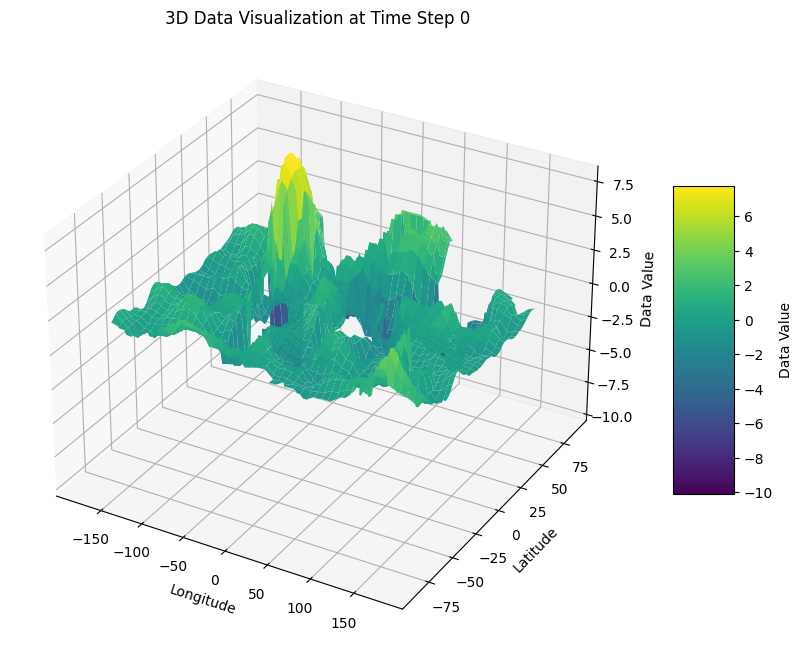

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 提取数据
data = da.isel(time=0).values  # 选取第一个时间步的数据
lon = da.coords['lon'].values  # 经度
lat = da.coords['lat'].values  # 纬度

# 创建网格
lon, lat = np.meshgrid(lon, lat)

# 创建图形和 3D 坐标轴
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制 3D 曲面图
surf = ax.plot_surface(lon, lat, data, cmap='viridis', edgecolor='none')

# 添加颜色条
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Data Value')

# 设置标签和标题
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Data Value')
ax.set_title('3D Data Visualization at Time Step 0')

# 显示图形
plt.show()



### 小结
- `xarray` 自带的 `plot()` 方法是最简单和最快捷的方式，特别适合初步探索和可视化。
- 使用 `matplotlib` 可以实现更加复杂和自定义的图形控制。
- 如果涉及到地理数据，使用 `cartopy` 与 `xarray` 的集成效果非常好，尤其是气候或地理空间数据。

## 总结
`XArray` 是一个用于处理带有标签（命名维度、坐标、属性等）的多维数组的 Python 库，旨在简化大数据集的处理，尤其是在科学数据和时间序列数据分析中。`XArray` 为数组增加了元数据的支持，使其在处理多维度数据时更加便捷和高效，类似于 `pandas` 之于表格数据。

### 核心组件

`XArray` 主要有两个核心数据结构：
1. **DataArray**：带有坐标和属性的多维数组。
2. **Dataset**：由多个 `DataArray` 组成的类似于数据表的集合。

#### 1. DataArray
`DataArray` 是 `XArray` 中的基本数据类型，它扩展了 NumPy 数组，并增加了以下元素：
- **数据值**：实际的多维数组数据。
- **维度（Dimensions）**：数据的轴标签，指定数组的每个维度，例如 `'time'`、`'latitude'`、`'longitude'`。
- **坐标（Coordinates）**：一组标签，可以用于每个维度的索引，例如时间轴的具体时间点。
- **属性（Attributes）**：附加的元数据，可以存储关于数据的描述性信息，如单位、来源等。

#### 2. Dataset
`Dataset` 是多个 `DataArray` 的容器，它类似于 `pandas` 的 `DataFrame`，用于管理不同变量之间的关系。每个变量都是一个 `DataArray`，并且共享相同的坐标。

### XArray 的特点

1. **多维数据的处理能力**：支持多维数据和复杂的维度处理，例如气象数据的四维数组（时间、经度、纬度、高度）。
2. **标签支持**：可以通过标签引用数据的维度和坐标，避免了手动管理多维数组中的维度索引。
3. **灵活的数据选择和索引**：支持使用坐标标签进行切片、索引和选择数据，非常直观且高效。
4. **与 NetCDF 兼容**：可以轻松地读写 `NetCDF` 文件，这在科学计算中非常常见。
5. **与 `pandas` 集成**：支持 `pandas` 风格的分组操作、时间序列分析、自动广播等功能。

### DataArray 的结构

`DataArray` 中有以下主要组成部分：

```python
import xarray as xr
import numpy as np

data = xr.DataArray(
    np.random.rand(4, 3),
    dims=["time", "location"],
    coords={"time": ["2020-01-01", "2020-01-02", "2020-01-03", "2020-01-04"],
            "location": ["A", "B", "C"]},
    attrs={"units": "meters"}
)

print(data)
```

输出：
```
<xarray.DataArray (time: 4, location: 3)>
array([[0.153, 0.871, 0.167],
       [0.946, 0.709, 0.867],
       [0.351, 0.754, 0.505],
       [0.593, 0.869, 0.222]])
Coordinates:
  * time       (time) <U10 '2020-01-01' '2020-01-02' '2020-01-03' '2020-01-04'
  * location   (location) <U1 'A' 'B' 'C'
Attributes:
    units:     meters
```

- **数据值**：存储在 `array` 中，`DataArray` 本身就是一个 NumPy 数组扩展。
- **维度 `dims`**：`time` 和 `location` 是这两维度的名称。
- **坐标 `coords`**：`time` 和 `location` 的具体值被存储为坐标。
- **属性 `attrs`**：`units` 是数据的附加元信息。

### Dataset 的结构

`Dataset` 是多个 `DataArray` 的集合：

```python
data = xr.Dataset({
    "temperature": (("time", "location"), np.random.rand(4, 3)),
    "precipitation": (("time", "location"), np.random.rand(4, 3)),
}, coords={"time": ["2020-01-01", "2020-01-02", "2020-01-03", "2020-01-04"],
           "location": ["A", "B", "C"]})

print(data)
```

输出：
```
<xarray.Dataset>
Dimensions:      (time: 4, location: 3)
Coordinates:
  * time         (time) <U10 '2020-01-01' '2020-01-02' '2020-01-03' '2020-01-04'
  * location     (location) <U1 'A' 'B' 'C'
Data variables:
    temperature  (time, location) float64 0.7747 0.5747 0.7089 0.8688 0.5567 ...
    precipitation (time, location) float64 0.6248 0.6984 0.4013 0.0467 0.8764 ...
```

- `Dataset` 包含两个 `DataArray`：`temperature` 和 `precipitation`。
- 坐标是 `time` 和 `location`，两者是共享的。

### 常用操作

#### 1. 数据选择与切片
`XArray` 支持基于标签的切片和索引：

```python
# 按坐标选择
data.sel(time="2020-01-01", location="A")

# 按位置选择
data.isel(time=0, location=0)
```

#### 2. 分组与聚合
类似 `pandas` 的 `groupby()`，可以按照维度进行分组：

```python
# 按年份分组
annual_mean = data.groupby('time.year').mean()
```

#### 3. 插值与重采样
可以进行重采样（如按月、按年）或插值：

```python
# 重采样到每月
monthly_data = data.resample(time='M').mean()

# 插值
interp_data = data.interp(time=["2020-01-01", "2020-01-15", "2020-02-01"])
```

#### 4. 广播与对齐
自动广播功能让你可以轻松处理不同维度的数据：

```python
data + data.mean(dim='location')
```

#### 5. 可视化
可以直接使用 `plot()` 函数绘制数据：

```python
data.temperature.isel(time=0).plot()
```

### XArray 与 NetCDF
`XArray` 支持直接读写 NetCDF 文件，这是一个广泛使用的科学数据格式：

```python
# 读取 NetCDF 文件
ds = xr.open_dataset("data.nc")

# 写入 NetCDF 文件
ds.to_netcdf("output.nc")
```

### 总结
- **灵活性**：`XArray` 提供了强大的多维数组处理能力，并支持带标签的数据操作，非常适合科学数据分析。
- **与 Pandas 类似的 API**：方便进行数据分组、聚合、选择等操作，且支持 `pandas` 风格的索引和切片。
- **与 NetCDF 兼容**：让它成为处理科学计算数据（如气象、海洋和卫星数据）的理想工具。

在时间序列数据和地理空间数据的分析和可视化中，`XArray` 是一个非常有用的库。